In [7]:
import pandas as pd

# Column names from parkinsons.names
columns = [
    "name", "MDVP:Fo(Hz)", "MDVP:Fhi(Hz)", "MDVP:Flo(Hz)",
    "MDVP:Jitter(%)", "MDVP:Jitter(Abs)", "MDVP:RAP", "MDVP:PPQ", "Jitter:DDP",
    "MDVP:Shimmer", "MDVP:Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5",
    "MDVP:APQ", "Shimmer:DDA", "NHR", "HNR",
    "status", "RPDE", "DFA", "spread1", "spread2", "D2", "PPE"
]


In [5]:
# Load dataset
df = pd.read_csv(r"C:\Users\venka\Desktop\pdv\ds\parkinsons.data",header=None, names=columns)

print(df.head())
print(df.shape)


             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0            name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)   
1  phon_R01_S01_1    119.99200     157.30200      74.99700         0.00784   
2  phon_R01_S01_2    122.40000     148.65000     113.81900         0.00968   
3  phon_R01_S01_3    116.68200     131.11100     111.55500         0.01050   
4  phon_R01_S01_4    116.67600     137.87100     111.36600         0.00997   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0  MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...   
1           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
2           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
3           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
4           0.00009   0.00502   0.00698     0.01505       0.05492  ...   

   Shimmer:DDA      NHR       HNR  status      RPDE       DFA    spread1  \
0  Shimmer

In [9]:
import re, numpy as np, pandas as pd
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

In [11]:
DATA_PATH = Path(r"C:\Users\venka\Desktop\pdv\ds\parkinsons.data")  

columns = [
    "name","MDVP:Fo(Hz)","MDVP:Fhi(Hz)","MDVP:Flo(Hz)",
    "MDVP:Jitter(%)","MDVP:Jitter(Abs)","MDVP:RAP","MDVP:PPQ","Jitter:DDP",
    "MDVP:Shimmer","MDVP:Shimmer(dB)","Shimmer:APQ3","Shimmer:APQ5",
    "MDVP:APQ","Shimmer:DDA","NHR","HNR",
    "status","RPDE","DFA","spread1","spread2","D2","PPE"
]
df = pd.read_csv(DATA_PATH, header=None, names=columns)

In [28]:
import re, pandas as pd
from pathlib import Path

cols = [
    "name","MDVP:Fo(Hz)","MDVP:Fhi(Hz)","MDVP:Flo(Hz)",
    "MDVP:Jitter(%)","MDVP:Jitter(Abs)","MDVP:RAP","MDVP:PPQ","Jitter:DDP",
    "MDVP:Shimmer","MDVP:Shimmer(dB)","Shimmer:APQ3","Shimmer:APQ5",
    "MDVP:APQ","Shimmer:DDA","NHR","HNR",
    "status","RPDE","DFA","spread1","spread2","D2","PPE"
]

path = Path(r"C:\Users\venka\Desktop\pdv\ds\parkinsons.data")

# Peek the first line to see if the file has a header:
with path.open("r", encoding="utf-8") as f:
    first = f.readline().strip()

has_header = first.lower().startswith("name,mdvp:fo(hz)") or first.startswith("name;") or first.startswith("name\t")

# Choose a flexible delimiter: comma by default, but tolerate ; or tab if present
sep = "," if "," in first else (";" if ";" in first else r"[\t,;]+")

if has_header:
    df = pd.read_csv(path, sep=sep, header=0, engine="python")
    # Ensure column order / names exactly match expected
    df = df[cols]  # will raise if mismatch (good for catching issues)
else:
    df = pd.read_csv(path, sep=sep, header=None, names=cols, engine="python")

# Drop empty trailing rows if any
df = df.dropna(how="all")

# Coerce all non-name columns to numeric (now should succeed)
for c in cols:
    if c != "name":
        df[c] = pd.to_numeric(df[c], errors="raise")

print("Shape should be (195, 24):", df.shape)
print(df.dtypes.head())
print(df.head(3))


Shape should be (195, 24): (195, 24)
name               object
MDVP:Fo(Hz)       float64
MDVP:Fhi(Hz)      float64
MDVP:Flo(Hz)      float64
MDVP:Jitter(%)    float64
dtype: object
             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.06545  0.02211  21.033       1  0.414783  0.815285 -4.813031   
1      0.09403  0.01929  19.085       1  0.458359  0.819521 -4.

In [31]:
def subject_id_from_name(s: str) -> str:
    m = re.search(r"R\d+", str(s))
    return m.group(0) if m else str(s).split("_")[0]

df["subject_id"] = df["name"].astype(str).apply(subject_id_from_name)
print("Unique subjects (should be ~31):", df["subject_id"].nunique())

# Quick group sanity
out = (df[["subject_id","status"]]
       .groupby("subject_id")
       .agg(count=("status","count"), pd_rate=("status","mean"))
       .sort_values("count", ascending=False)
       .head())
print(out)


Unique subjects (should be ~31): 1
            count   pd_rate
subject_id                 
R01           195  0.753846


In [33]:
print("shape:", df.shape)
print("dtypes:\n", df.dtypes)

# peek a few names
print("\nSample names:")
print(df["name"].head(15).to_list())

# how many distinct raw names?
print("\nRaw name nunique:", df["name"].nunique())

# what Rxx tokens do we find?
tokens = df["name"].astype(str).str.extract(r'(R\d{2})', expand=False)
print("\nCounts of extracted Rxx:")
print(tokens.value_counts().head(10))
print("Unique Rxx tokens:", tokens.nunique(), " (expected ≈31)")


shape: (195, 25)
dtypes:
 name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
subject_id           object
dtype: object

Sample names:
['phon_R01_S01_1', 'phon_R01_S01_2', 'phon_R01_S01_3', 'phon_R01_S01_4', 'phon_R01_S01_5', 'phon_R01_S01_6', 'phon_R01_S02_1', 'phon_R01_S02_2', 'phon_R01_S02_3', 'phon_R01_S02_4', 'phon_R01_S02_5', 'phon_R01_S02_6', 'phon_R01_S04_1', 'phon_R01_

In [37]:
import re

def get_subject_id(s: str) -> str:
    s = str(s)
    # Match R followed by 1–2 digits, e.g. R01...R31
    m = re.search(r"R\d{1,2}", s)
    return m.group(0) if m else s

df["subject_id"] = df["name"].apply(get_subject_id)

print("Unique subjects:", df["subject_id"].nunique())
print(df["subject_id"].value_counts().sort_index().head(10))


Unique subjects: 1
subject_id
R01    195
Name: count, dtype: int64


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [41]:
X = df.drop(columns=["name", "status", "subject_id"])
y = df["status"]

In [46]:
X

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [48]:
y

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [52]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=10, gamma="scale", probability=True))
])

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc")

print("CV AUC:", cv_scores.mean(), "±", cv_scores.std())

CV AUC: 0.9574457215836526 ± 0.02385994112555426


In [56]:
clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=10, probability=True))])

In [58]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

In [60]:
print("\n=== Test Set Results ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


=== Test Set Results ===
ROC-AUC: 0.9620689655172414
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39

Confusion matrix:
 [[ 8  2]
 [ 2 27]]


In [62]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GroupKFold, GroupShuffleSplit, StratifiedKFold, train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

In [66]:
try:
    import xgboost as xgb
except ImportError as e:
    raise SystemExit("Please install xgboost first: pip install xgboost") from e

In [68]:
X = df.drop(columns=["name", "status", "subject_id"])
y = df["status"].astype(int)
groups = df["subject_id"].astype(str)
use_groups = groups.nunique() > 1   # auto-detect

In [70]:
if use_groups:
    CV = GroupKFold(n_splits=5)
    cv_kwargs = dict(cv=CV, groups=groups)
    print("Using GroupKFold (n_splits=5) with subject_id (unique groups:", groups.nunique(), ")")
else:
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_kwargs = dict(cv=CV)
    print("Using StratifiedKFold (n_splits=5), groups not available")

Using StratifiedKFold (n_splits=5), groups not available


In [72]:
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, class_weight="balanced"))
])

svm_grid = {
    "svc__C":     [0.5, 1, 3, 10, 30, 100],
    "svc__gamma": ["scale", 0.03, 0.1]
}

In [74]:
pos = (y == 1).sum()
neg = (y == 0).sum()
spw = max(1.0, neg / max(1, pos))

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=400,
    tree_method="hist",
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    max_depth=3,
    reg_lambda=1.0,
    scale_pos_weight=spw,
    random_state=42
)

In [76]:
xgb_grid = {
    "max_depth": [3, 4],
    "min_child_weight": [1, 2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.7, 0.9],
    "n_estimators": [300, 500],
    "learning_rate": [0.03, 0.07]
}


In [78]:
scoring = {"acc": "accuracy", "auc": "roc_auc"}

svm_cv = cross_validate(svm_pipe, X, y, scoring=scoring, n_jobs=-1, **cv_kwargs)
print(f"\nSVM (baseline)  | ACC: {svm_cv['test_acc'].mean():.3f} ± {svm_cv['test_acc'].std():.3f} | "
      f"AUC: {svm_cv['test_auc'].mean():.3f} ± {svm_cv['test_auc'].std():.3f}")

xgb_cv = cross_validate(xgb_clf, X, y, scoring=scoring, n_jobs=-1, **cv_kwargs)
print(f"XGB (baseline)  | ACC: {xgb_cv['test_acc'].mean():.3f} ± {xgb_cv['test_acc'].std():.3f} | "
      f"AUC: {xgb_cv['test_auc'].mean():.3f} ± {xgb_cv['test_auc'].std():.3f}")


SVM (baseline)  | ACC: 0.815 ± 0.034 | AUC: 0.944 ± 0.033
XGB (baseline)  | ACC: 0.918 ± 0.034 | AUC: 0.971 ± 0.017


In [80]:
svm_gs = GridSearchCV(svm_pipe, svm_grid, scoring="roc_auc", n_jobs=-1, **cv_kwargs)
svm_gs.fit(X, y, **({"groups": groups} if use_groups else {}))
print("\nBest SVM params:", svm_gs.best_params_, "| CV AUC:", f"{svm_gs.best_score_:.3f}")

xgb_gs = GridSearchCV(xgb_clf, xgb_grid, scoring="roc_auc", n_jobs=-1, **cv_kwargs)
xgb_gs.fit(X, y, **({"groups": groups} if use_groups else {}))
print("Best XGB params:", xgb_gs.best_params_, "| CV AUC:", f"{xgb_gs.best_score_:.3f}")

best_svm = svm_gs.best_estimator_
best_xgb = xgb_gs.best_estimator_


Best SVM params: {'svc__C': 10, 'svc__gamma': 0.1} | CV AUC: 0.979
Best XGB params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 1.0} | CV AUC: 0.980


In [82]:
if use_groups:
    splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
    tr_idx, te_idx = next(splitter.split(X, y, groups))
else:
    tr_idx, te_idx = train_test_split(np.arange(len(X)), test_size=0.2, stratify=y, random_state=42)


In [84]:
X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

In [86]:
best_svm.fit(X_tr, y_tr)
best_xgb.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [88]:
svm_proba = best_svm.predict_proba(X_te)[:, 1]
svm_pred  = (svm_proba >= 0.5).astype(int)

In [90]:
xgb_proba = best_xgb.predict_proba(X_te)[:, 1]
xgb_pred  = (xgb_proba >= 0.5).astype(int)

In [92]:
print("\n=== HOLD-OUT (SVM) ===")
print("ACC:", f"{accuracy_score(y_te, svm_pred):.3f}", "| AUC:", f"{roc_auc_score(y_te, svm_proba):.3f}")
print(classification_report(y_te, svm_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_te, svm_pred))


=== HOLD-OUT (SVM) ===
ACC: 0.897 | AUC: 0.983
              precision    recall  f1-score   support

           0      0.800     0.800     0.800        10
           1      0.931     0.931     0.931        29

    accuracy                          0.897        39
   macro avg      0.866     0.866     0.866        39
weighted avg      0.897     0.897     0.897        39

Confusion matrix:
 [[ 8  2]
 [ 2 27]]


In [94]:
print("\n=== HOLD-OUT (XGBoost) ===")
print("ACC:", f"{accuracy_score(y_te, xgb_pred):.3f}", "| AUC:", f"{roc_auc_score(y_te, xgb_proba):.3f}")
print(classification_report(y_te, xgb_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_te, xgb_pred))


=== HOLD-OUT (XGBoost) ===
ACC: 0.923 | AUC: 0.976
              precision    recall  f1-score   support

           0      0.889     0.800     0.842        10
           1      0.933     0.966     0.949        29

    accuracy                          0.923        39
   macro avg      0.911     0.883     0.896        39
weighted avg      0.922     0.923     0.922        39

Confusion matrix:
 [[ 8  2]
 [ 1 28]]


In [96]:
svm_pi = permutation_importance(best_svm, X_te, y_te, n_repeats=30, random_state=0, scoring="roc_auc")
svm_imp = pd.DataFrame({"feature": X.columns, "imp_auc_drop": svm_pi.importances_mean})
svm_imp = svm_imp.sort_values("imp_auc_drop", ascending=False)
print("\nTop 10 (SVM permutation AUC drop):")
print(svm_imp.head(10).to_string(index=False))


Top 10 (SVM permutation AUC drop):
         feature  imp_auc_drop
     MDVP:Fo(Hz)      0.131954
         spread2      0.098851
             DFA      0.050805
         spread1      0.050345
             PPE      0.031149
            RPDE      0.030000
    MDVP:Fhi(Hz)      0.024598
             HNR      0.018506
    MDVP:Flo(Hz)      0.015057
MDVP:Jitter(Abs)      0.008506


In [102]:
from sklearn.inspection import permutation_importance

xgb_pi = permutation_importance(best_xgb, X_te, y_te, n_repeats=30, random_state=0, scoring="roc_auc")
xgb_perm = (
    pd.DataFrame({"feature": X.columns, "imp_auc_drop": xgb_pi.importances_mean})
      .sort_values("imp_auc_drop", ascending=False)
)
print("\nTop 10 (XGB permutation AUC drop):")
print(xgb_perm.head(10).to_string(index=False))



Top 10 (XGB permutation AUC drop):
       feature  imp_auc_drop
  MDVP:Fhi(Hz)      0.055977
           PPE      0.038276
       spread2      0.030115
           DFA      0.018161
   MDVP:Fo(Hz)      0.013218
       spread1      0.011264
MDVP:Jitter(%)      0.003448
          RPDE      0.002759
  Shimmer:APQ3      0.002299
      MDVP:RAP      0.001149


In [106]:
# Robust mapping: supports both 'f12' and actual column names
score = best_xgb.get_booster().get_score(importance_type="gain")  # dict

def map_key(k: str) -> str:
    k = str(k)
    if k.startswith("f") and k[1:].isdigit():        # 'f0','f1',...
        return X.columns[int(k[1:])]
    return k                                         # already a real column name

xgb_imp = (
    pd.Series(score)
      .rename(index=map_key)
      .sort_values(ascending=False)
      .rename("gain")
      .reset_index()
      .rename(columns={"index": "feature"})
)

print("\nTop 10 (XGB gain):")
print(xgb_imp.head(10).to_string(index=False))



Top 10 (XGB gain):
     feature     gain
         PPE 7.031806
     spread1 3.685767
MDVP:Flo(Hz) 2.962903
    MDVP:APQ 2.283299
  Jitter:DDP 2.275099
Shimmer:APQ5 2.262462
 MDVP:Fo(Hz) 1.967442
    MDVP:RAP 1.455963
MDVP:Shimmer 1.230259
Shimmer:APQ3 1.181397


In [108]:
from sklearn.inspection import permutation_importance

xgb_pi = permutation_importance(best_xgb, X_te, y_te, n_repeats=30, random_state=0, scoring="roc_auc")
xgb_perm = (
    pd.DataFrame({"feature": X.columns, "imp_auc_drop": xgb_pi.importances_mean})
      .sort_values("imp_auc_drop", ascending=False)
)
print("\nTop 10 (XGB permutation AUC drop):")
print(xgb_perm.head(10).to_string(index=False))



Top 10 (XGB permutation AUC drop):
       feature  imp_auc_drop
  MDVP:Fhi(Hz)      0.055977
           PPE      0.038276
       spread2      0.030115
           DFA      0.018161
   MDVP:Fo(Hz)      0.013218
       spread1      0.011264
MDVP:Jitter(%)      0.003448
          RPDE      0.002759
  Shimmer:APQ3      0.002299
      MDVP:RAP      0.001149


In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# ========== 1) ROC Curves ==========
plt.figure(figsize=(7,5))

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

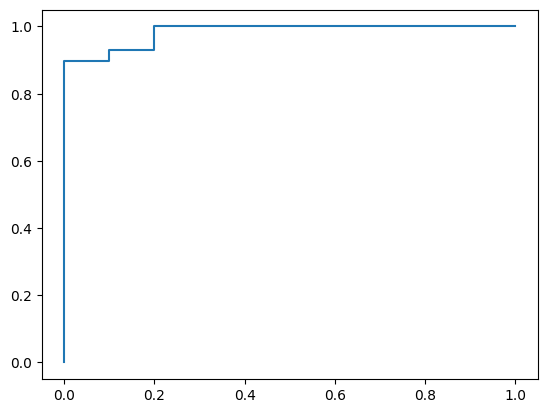

In [112]:
fpr_svm, tpr_svm, _ = roc_curve(y_te, svm_proba)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={roc_auc_svm:.3f})")


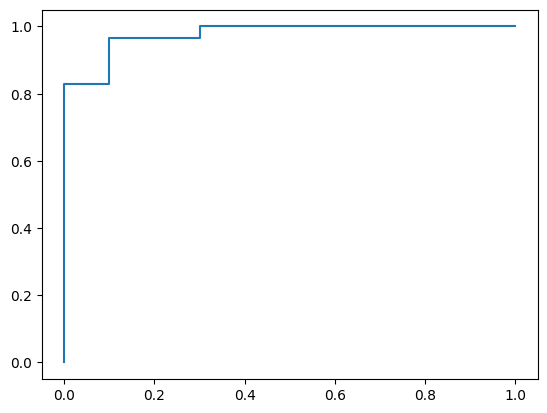

In [114]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_te, xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={roc_auc_xgb:.3f})")

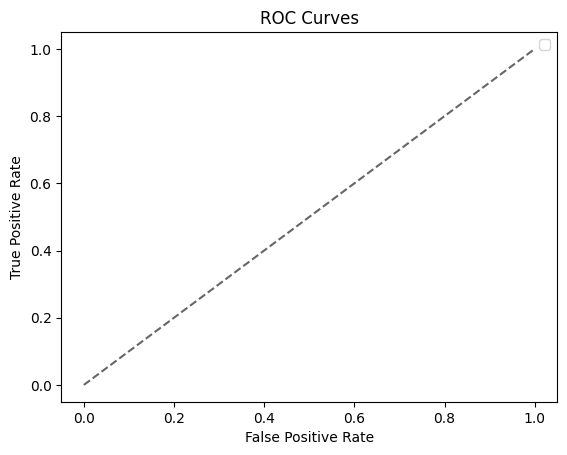

In [116]:
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

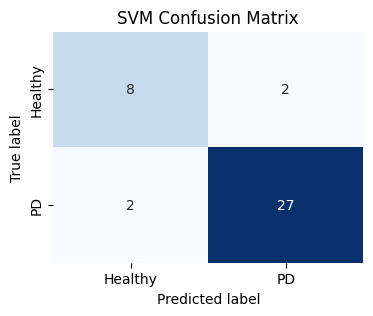

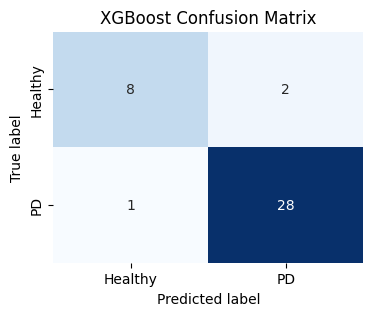

In [118]:
def plot_conf_matrix(cm, model_name):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Healthy","PD"], yticklabels=["Healthy","PD"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

plot_conf_matrix(confusion_matrix(y_te, svm_pred), "SVM")
plot_conf_matrix(confusion_matrix(y_te, xgb_pred), "XGBoost")

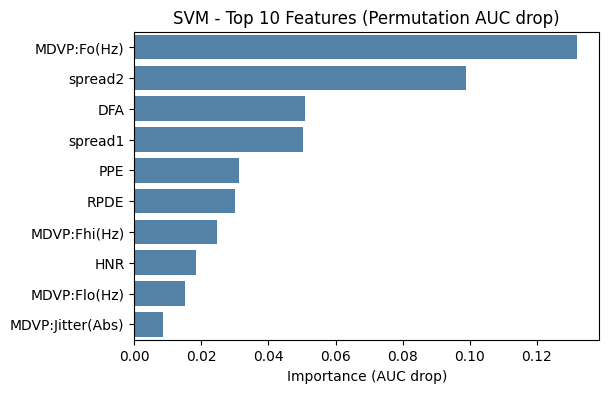

In [120]:
plt.figure(figsize=(6,4))
sns.barplot(x="imp_auc_drop", y="feature", 
            data=svm_imp.head(10), color="steelblue")
plt.title("SVM - Top 10 Features (Permutation AUC drop)")
plt.xlabel("Importance (AUC drop)")
plt.ylabel("")
plt.show()


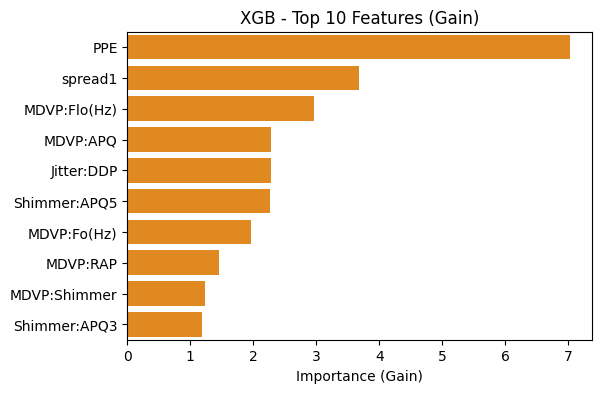

In [122]:
plt.figure(figsize=(6,4))
sns.barplot(x="gain", y="feature", 
            data=xgb_imp.head(10), color="darkorange")
plt.title("XGB - Top 10 Features (Gain)")
plt.xlabel("Importance (Gain)")
plt.ylabel("")
plt.show()

NameError: name 'predict_pd_proba' is not defined

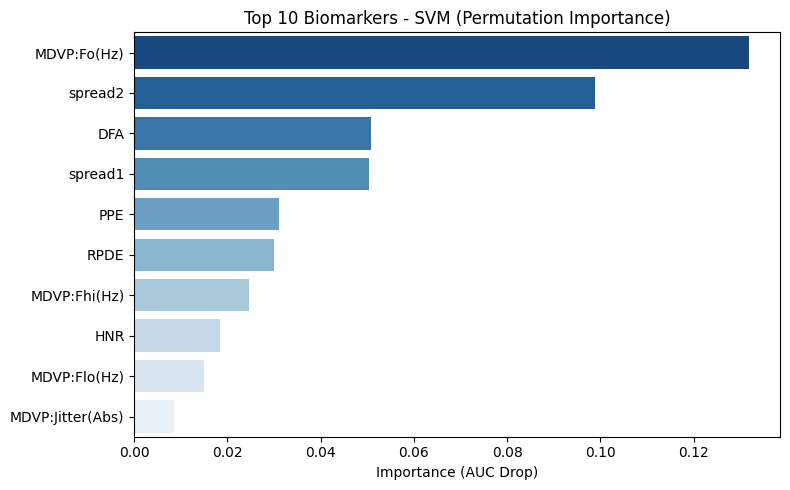

In [127]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=svm_imp.head(10),
    x="imp_auc_drop", y="feature", palette="Blues_r"
)
plt.title("Top 10 Biomarkers - SVM (Permutation Importance)")
plt.xlabel("Importance (AUC Drop)")
plt.ylabel("")
plt.tight_layout()
plt.show()

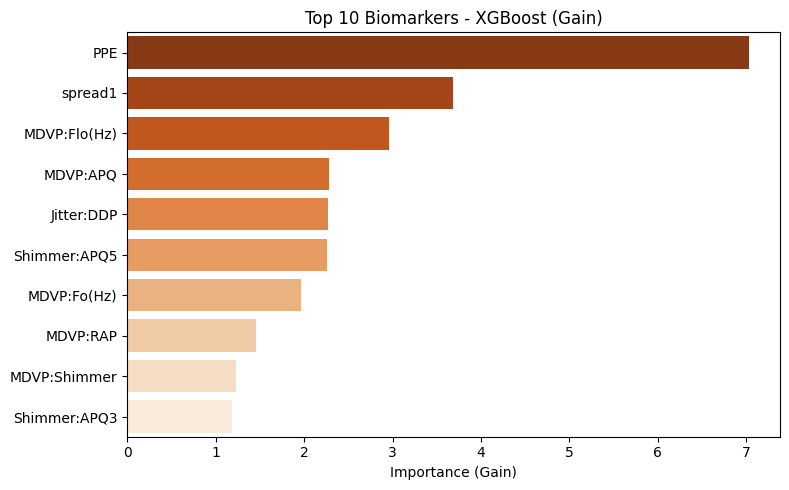

In [129]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=xgb_imp.head(10),
    x="gain", y="feature", palette="Oranges_r"
)
plt.title("Top 10 Biomarkers - XGBoost (Gain)")
plt.xlabel("Importance (Gain)")
plt.ylabel("")
plt.tight_layout()
plt.show()

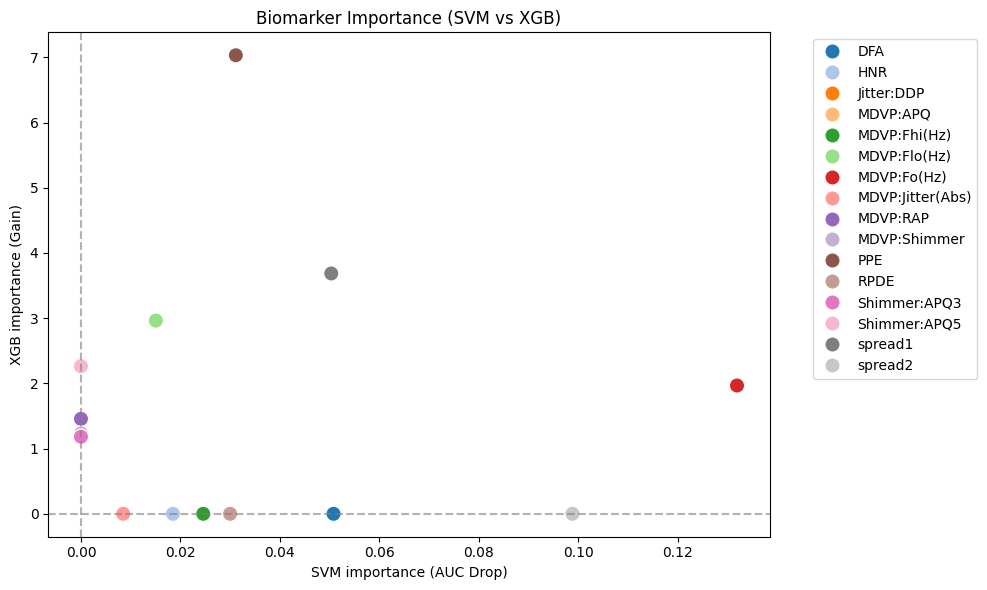

In [131]:
svm_top = svm_imp.head(10).set_index("feature")
xgb_top = xgb_imp.head(10).set_index("feature")

merged = svm_top.join(xgb_top, how="outer").fillna(0).reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged,
    x="imp_auc_drop", y="gain", hue="feature", s=120, palette="tab20"
)
plt.axhline(0, color="grey", linestyle="--", alpha=0.6)
plt.axvline(0, color="grey", linestyle="--", alpha=0.6)
plt.title("Biomarker Importance (SVM vs XGB)")
plt.xlabel("SVM importance (AUC Drop)")
plt.ylabel("XGB importance (Gain)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [133]:
import numpy as np
import pandas as pd

def predict_pd_proba(features: dict, model="xgb"):
    """
    Predict Parkinson's probability for a new sample.

    features: dict
        Keys must match the dataset feature columns (22 voice measures).
        Example: {"MDVP:Fo(Hz)": 120.0, "MDVP:Fhi(Hz)": 145.0, ...}

    model: str
        "svm" or "xgb" (default = "xgb")

    Returns: probability of PD
    """
    # Pick model
    if model == "svm":
        clf = best_svm
    elif model == "xgb":
        clf = best_xgb
    else:
        raise ValueError("Model must be 'svm' or 'xgb'")

    # Ensure correct column order
    x_input = pd.DataFrame([features], columns=X.columns)

    # Get probability
    proba = clf.predict_proba(x_input)[0, 1]
    return proba


In [135]:
# Example patient’s voice feature set (values are illustrative!)
sample = {
    "MDVP:Fo(Hz)": 120.0,
    "MDVP:Fhi(Hz)": 145.0,
    "MDVP:Flo(Hz)": 100.0,
    "MDVP:Jitter(%)": 0.005,
    "MDVP:Jitter(Abs)": 0.00004,
    "MDVP:RAP": 0.002,
    "MDVP:PPQ": 0.002,
    "Jitter:DDP": 0.006,
    "MDVP:Shimmer": 0.03,
    "MDVP:Shimmer(dB)": 0.25,
    "Shimmer:APQ3": 0.015,
    "Shimmer:APQ5": 0.020,
    "MDVP:APQ": 0.022,
    "Shimmer:DDA": 0.045,
    "NHR": 0.02,
    "HNR": 22.0,
    "RPDE": 0.45,
    "DFA": 0.72,
    "spread1": -4.0,
    "spread2": 0.30,
    "D2": 2.35,
    "PPE": 0.28
}

print("PD probability (XGB):", predict_pd_proba(sample, model="xgb"))
print("PD probability (SVM):", predict_pd_proba(sample, model="svm"))


PD probability (XGB): 0.99892163
PD probability (SVM): 0.9999968042668186
